# LangGraph-Building-Graphs

- Author: [Donghak Lee](https://github.com/stsr1284)
- Design: 
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb)

## Overview

In this tutorial, you will learn how to use `LangGraph` to create foundational graph structures.

You will learn the following:

1. The steps to define a graph
2. How to use conditional edges and different flow variations
3. Re-search graph structure
4. Multi-LLM graph structure
5. Query rewrite graph structure
6. SQL RAG graph structure

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Steps for Defining a Graph](#steps-for-defining-a-graph)
- [Various Graph Structures  ](#various-graph-structures)

### References

- [LangChain runnables Graph](https://python.langchain.com/api_reference/core/runnables/langchain_core.runnables.graph.Graph.html#)
- [LangGraph Graph Definitions](https://langchain-ai.github.io/langgraph/reference/graphs/)
----

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can check out the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain_core",
        "langgraph",
        "typing",
        "langchain_teddynote",
    ],
    verbose=False,
    upgrade=False,
)

You can set API keys in a `.env` file or set them manually.

[Note] If you’re not using the `.env` file, no worries! Just enter the keys directly in the cell below, and you’re good to go.

In [10]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "LangGraph-Building-Graphs",
    }
)

Environment variables have been set successfully.


You can alternatively set API keys such as `OPENAI_API_KEY` in a `.env` file and load them.

[Note] This is not necessary if you've already set the required API keys in previous steps.

In [ ]:
# Load API keys from .env file
from dotenv import load_dotenv

load_dotenv(override=True)

## Steps for Defining a Graph  
To define a graph with `LangGraph`, you need to define `State`, `Node`, and `Graph`, and then compile them.  

If necessary, you can flexibly adjust the graph flow by adding conditional edges to nodes using `add_conditional_edges()`.

### Define State  

`State` defines the shared state between the nodes in the graph.  

It uses the `TypedDict` format and adds metadata to type hints using `Annotated` to provide detailed information.

In [3]:
from typing import TypedDict, Annotated, List
from langchain_core.documents import Document
import operator


# Define State
class GraphState(TypedDict):
    context: Annotated[List[Document], operator.add]
    answer: Annotated[List[Document], operator.add]
    question: Annotated[str, "user question"]
    sql_query: Annotated[str, "sql query"]
    binary_score: Annotated[str, "binary score yes or no"]

### Define Node  
Define the nodes that process each step.  

These are usually implemented as Python functions, with `State` as both input and output.

In [4]:
def retrieve(state: GraphState) -> GraphState:
    # retrieve: search
    documents = "searched documents"
    return {"context": documents}


def rewrite_query(state: GraphState) -> GraphState:
    # Query Transform: rewrite query
    documents = "searched documents"
    return GraphState(context=documents)


def llm_gpt_execute(state: GraphState) -> GraphState:
    # LLM Execution
    answer = "GPT generated answer"
    return GraphState(answer=answer)


def llm_claude_execute(state: GraphState) -> GraphState:
    # LLM Execution
    answer = "Claude generated answer"
    return GraphState(answer=answer)


def relevance_check(state: GraphState) -> GraphState:
    # Relevance Check
    binary_score = "Relevance Score"
    return GraphState(binary_score=binary_score)


def sum_up(state: GraphState) -> GraphState:
    # sum_up: Aggregate Results
    answer = "Aggregate Results"
    return GraphState(answer=answer)


def search_on_web(state: GraphState) -> GraphState:
    # Search on Web
    documents = state["context"] = "existing documents"
    searched_documents = "searched documents"
    documents += searched_documents
    return GraphState(context=documents)


def get_table_info(state: GraphState) -> GraphState:
    # Get Table Info
    table_info = "table information"
    return GraphState(context=table_info)


def generate_sql_query(state: GraphState) -> GraphState:
    # Make SQL Query
    sql_query = "SQL query"
    return GraphState(sql_query=sql_query)


def execute_sql_query(state: GraphState) -> GraphState:
    # Execute SQL Query
    sql_result = "SQL result"
    return GraphState(context=sql_result)


def validate_sql_query(state: GraphState) -> GraphState:
    # Validate SQL Query
    binary_score = "SQL query validation result"
    return GraphState(binary_score=binary_score)


def handle_error(state: GraphState) -> GraphState:
    # Error Handling
    error = "error occurred"
    return GraphState(context=error)


def decision(state: GraphState) -> GraphState:
    # Decision Making
    decision = "decision"
    # Additional logic can be added here.

    if state["binary_score"] == "yes":
        return "exit"
    else:
        return "re_search"

### Define Graph  
Connect nodes with `Edge`.  

Using conditional edges, you can determine the next `Node` to execute based on the current `State`.

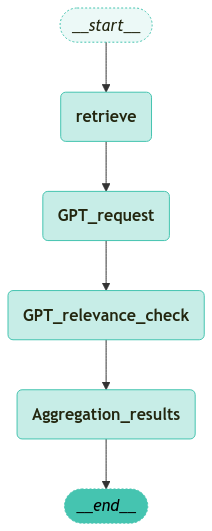

In [5]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_teddynote.graphs import visualize_graph

# Import StateGraph and END from langgraph.graph.
workflow = StateGraph(GraphState)

# Add nodes.
workflow.add_node("retrieve", retrieve)
workflow.add_node("GPT_request", llm_gpt_execute)
workflow.add_node("GPT_relevance_check", relevance_check)
workflow.add_node("Aggregation_results", sum_up)

# Connect nodes.
workflow.add_edge("retrieve", "GPT_request")
workflow.add_edge("GPT_request", "GPT_relevance_check")
workflow.add_edge("GPT_relevance_check", "Aggregation_results")
workflow.add_edge("Aggregation_results", END)

# Set the entry point.
workflow.set_entry_point("retrieve")

# Set up memory storage for recording.
memory = MemorySaver()

# Compile the graph.
app = workflow.compile(checkpointer=memory)

# Visualize the graph
visualize_graph(app)

## Various Graph Structures  

In this section, you will learn about different graph structures using conditional edges.

The graph structures you will learn are as follows:
1. Re-search graph structure
2. Multi-LLM graph structure
3. Query rewrite graph structure
4. SQL RAG graph structure

### Re-search Graph Structure
The Re-search Graph inspects the output from the GPT model and selects either `re_search` or `exit`. This allows you to obtain more relevant results for the query.

The execution flow is as follows:

- A conditional edge is added to the `Aggregation_results` node.
- The `GPT_relevance_check` node checks the relevance of the output from the `GPT_request` node.  
- Based on the result of the relevance check, the `Aggregation_results` node decides whether to `re_search` or `exit` using the `State` information.

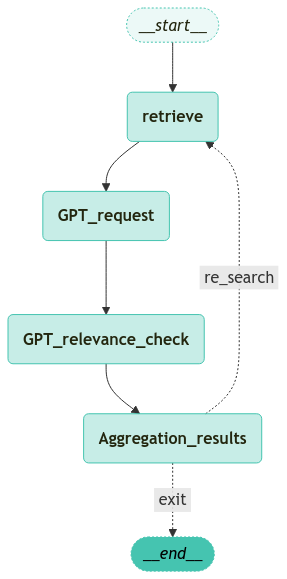

In [6]:
# Import StateGraph and END from langgraph.graph.
workflow = StateGraph(GraphState)

# Add nodes.
workflow.add_node("retrieve", retrieve)
workflow.add_node("GPT_request", llm_gpt_execute)
workflow.add_node("GPT_relevance_check", relevance_check)
workflow.add_node("Aggregation_results", sum_up)

# Connect nodes.
workflow.add_edge("retrieve", "GPT_request")
workflow.add_edge("GPT_request", "GPT_relevance_check")
workflow.add_edge("GPT_relevance_check", "Aggregation_results")

# Add conditional edges.
workflow.add_conditional_edges(
    "Aggregation_results",  # Pass the result from the relevance check node to the decision function.
    decision,
    {
        "re_search": "retrieve",  # If the relevance check result is ambiguous, generate the answer again.
        "exit": END,  # If relevant, exit.
    },
)

# Set the entry point.
workflow.set_entry_point("retrieve")

# Set up memory storage for recording.
memory = MemorySaver()

# Compile the graph.
app = workflow.compile(checkpointer=memory)

# Visualize the graph
visualize_graph(app)

### Multi-LLM Graph Structure  
The Multi-LLM graph uses various LLM models to generate results.

This allows for obtaining a variety of answers.

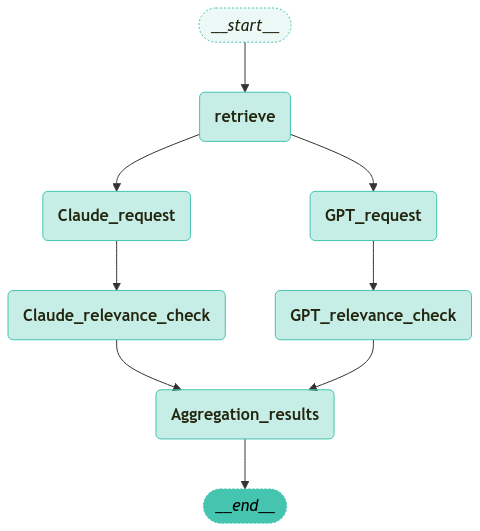

In [7]:
# Import StateGraph and END from langgraph.graph.
workflow = StateGraph(GraphState)

# Add nodes.
workflow.add_node("retrieve", retrieve)
workflow.add_node("GPT_request", llm_gpt_execute)
workflow.add_node("GPT_relevance_check", relevance_check)

# add a new node for Claude
workflow.add_node("Claude_request", llm_claude_execute)
# add a new node for checking Claude's relevance
workflow.add_node("Claude_relevance_check", relevance_check)

workflow.add_node("Aggregation_results", sum_up)

# Connect nodes.
workflow.add_edge("retrieve", "GPT_request")
workflow.add_edge("GPT_request", "GPT_relevance_check")
workflow.add_edge("GPT_relevance_check", "Aggregation_results")

# connect the new node to the entry point
workflow.add_edge("retrieve", "Claude_request")
# connect the "Claude_request" node to the "Claude_relevance_check"
workflow.add_edge("Claude_request", "Claude_relevance_check")
workflow.add_edge("Claude_relevance_check", "Aggregation_results")
workflow.add_edge("Aggregation_results", END)

# Set the entry point.
workflow.set_entry_point("retrieve")

# Set up memory storage for recording.
memory = MemorySaver()

# Compile the graph.
app = workflow.compile(checkpointer=memory)

# Visualize the graph
visualize_graph(app)

### Query Rewrite Graph  
The Query Rewrite Graph is a structure that adds the `rewrite_query` node to the Re-search Graph structure.  

The rewrite node for the query rewrites the question to obtain more refined results.

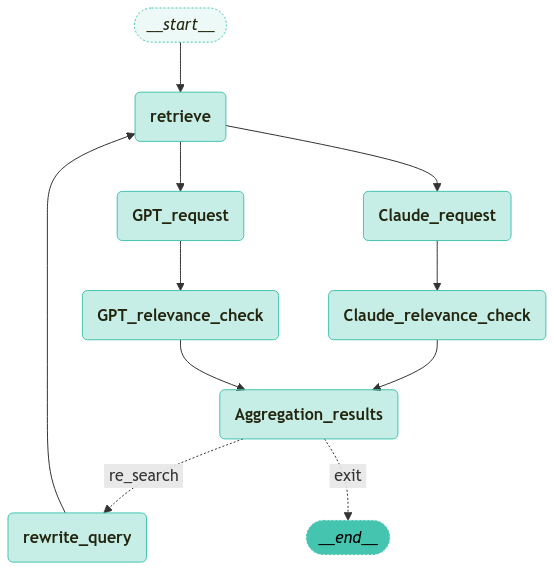

In [8]:
# Import StateGraph and END from langgraph.graph.
workflow = StateGraph(GraphState)

# Add nodes.
workflow.add_node("retrieve", retrieve)

# add a new node for rewriting the query
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("GPT_request", llm_gpt_execute)
workflow.add_node("Claude_request", llm_claude_execute)
workflow.add_node("GPT_relevance_check", relevance_check)
workflow.add_node("Claude_relevance_check", relevance_check)
workflow.add_node("Aggregation_results", sum_up)

# Connect nodes.
workflow.add_edge("retrieve", "GPT_request")
workflow.add_edge("retrieve", "Claude_request")
workflow.add_edge("rewrite_query", "retrieve")
workflow.add_edge("GPT_request", "GPT_relevance_check")
workflow.add_edge("GPT_relevance_check", "Aggregation_results")
workflow.add_edge("Claude_request", "Claude_relevance_check")
workflow.add_edge("Claude_relevance_check", "Aggregation_results")

# Add conditional edges. (4)
workflow.add_conditional_edges(
    "Aggregation_results",  # Pass the result from the relevance check node to the decision function.
    decision,
    {
        "re_search": "rewrite_query",  # If the relevance check result is ambiguous, generate the answer again.
        "exit": END,  # If relevant, exit.
    },
)

# Set the entry point.
workflow.set_entry_point("retrieve")

# Set up memory storage for recording.
memory = MemorySaver()

# Compile the graph.
app = workflow.compile(checkpointer=memory)

# Visualize the graph
visualize_graph(app)

### SQL RAG Graph Structure  
The SQL RAG Graph is a structure that combines Conventional RAG with SQL RAG. 

It uses rewrite nodes for the question and query to generate precise results based on the requirements.

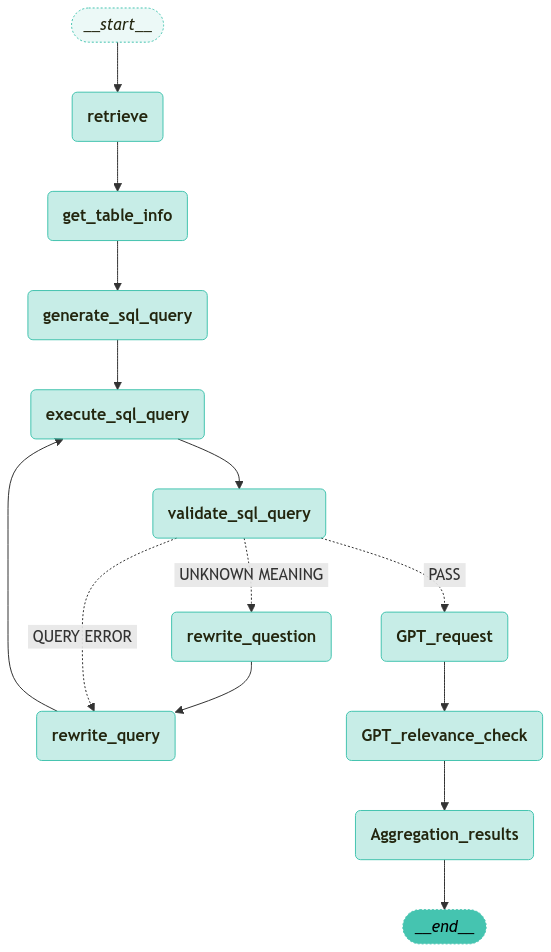

In [9]:
# Import StateGraph and END from langgraph.graph
workflow = StateGraph(GraphState)

# Add nodes.
workflow.add_node("retrieve", retrieve)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("rewrite_question", rewrite_query)
workflow.add_node("GPT_request", llm_gpt_execute)
workflow.add_node("GPT_relevance_check", relevance_check)
workflow.add_node("Aggregation_results", sum_up)
workflow.add_node("get_table_info", get_table_info)
workflow.add_node("generate_sql_query", generate_sql_query)
workflow.add_node("execute_sql_query", execute_sql_query)
workflow.add_node("validate_sql_query", validate_sql_query)

# Connect nodes.
workflow.add_edge("retrieve", "get_table_info")
workflow.add_edge("get_table_info", "generate_sql_query")
workflow.add_edge("generate_sql_query", "execute_sql_query")
workflow.add_edge("execute_sql_query", "validate_sql_query")

workflow.add_conditional_edges(
    "validate_sql_query",
    decision,
    {
        "QUERY ERROR": "rewrite_query",
        "UNKNOWN MEANING": "rewrite_question",
        "PASS": "GPT_request",
    },
)

workflow.add_edge("rewrite_query", "execute_sql_query")
workflow.add_edge("rewrite_question", "rewrite_query")
workflow.add_edge("GPT_request", "GPT_relevance_check")
workflow.add_edge("GPT_relevance_check", "Aggregation_results")
workflow.add_edge("Aggregation_results", END)

# Set the entry point.
workflow.set_entry_point("retrieve")

# Set up memory storage for recording.
memory = MemorySaver()

# Compile the graph.
app = workflow.compile(checkpointer=memory)

# Visualize the graph
visualize_graph(app)